# Library Imports

In [ ]:
import os
import cv2
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Mount drive to load dataset from drive

In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


# Function to load and preprocess images


In [ ]:
def load_images(data_dir):
    images = []
    labels = []
    class_names = os.listdir(data_dir)
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            image_path = os.path.join(class_dir, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            image = cv2.resize(image, IMAGE_SIZE)
            images.append(image)
            labels.append(class_name)
    return images, labels

# Define constants

In [ ]:
IMAGE_SIZE = (100, 100)
BATCH_SIZE = 32
NUM_CLASSES = 3  # Number of fruit size categories (e.g., small, medium, large)


In [ ]:
# Load images and labels
data_dir = '/content/drive/My Drive/Fruit classification'
images, labels = load_images(data_dir)

# Convert labels to numerical values
label_to_id = {'Apple': 0, 'Banana': 1, 'Pear': 2}
labels_numeric = [label_to_id[label] for label in labels]

# One-hot encode labels
from keras.utils import to_categorical
labels_one_hot = to_categorical(labels_numeric, NUM_CLASSES)

# Split dataset and visualize distribution

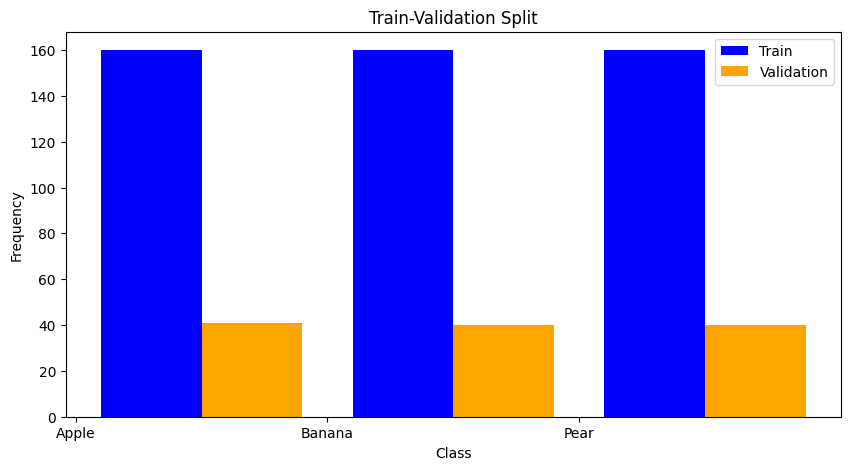

In [ ]:
# Convert to numpy arrays
images_np = np.array(images)

# Split data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images_np, labels_one_hot, test_size=0.2, random_state=42, stratify=labels_one_hot)

train_images = train_images / 255.0
val_images = val_images / 255.0

# Visualize train-validation split
plt.figure(figsize=(10, 5))
plt.hist([np.argmax(train_labels, axis=1), np.argmax(val_labels, axis=1)], bins=range(4), color=['blue', 'orange'], label=['Train', 'Validation'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Train-Validation Split')
plt.xticks(range(3), ['Apple', 'Banana', 'Pear'])
plt.legend()
plt.show()





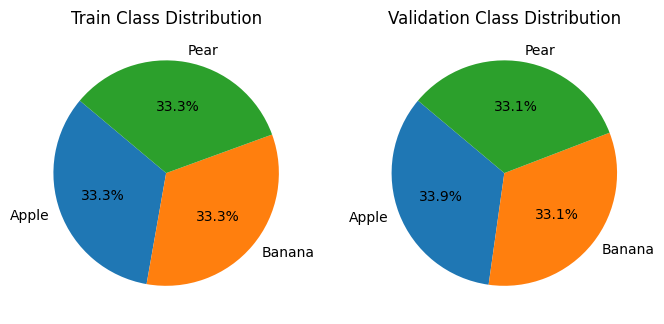

In [ ]:
# Define a dictionary to map numeric labels to class names
label_to_class = {0: 'Apple', 1: 'Banana', 2: 'Pear'}

# Class distribution of the images (pie chart)
train_class_distribution = np.sum(train_labels, axis=0)
val_class_distribution = np.sum(val_labels, axis=0)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.pie(train_class_distribution, labels=label_to_class.values(), autopct='%1.1f%%', startangle=140)
plt.title('Train Class Distribution')

plt.subplot(1, 2, 2)
plt.pie(val_class_distribution, labels=label_to_class.values(), autopct='%1.1f%%', startangle=140)
plt.title('Validation Class Distribution')

plt.show()

# convolutional neural network

In [ ]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(100,100, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])


# Model Training

In [ ]:
from keras.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score


# Define metrics callback
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_val, axis=1)

        precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
        recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
        f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

        print(f'Epoch {epoch + 1} - Validation Metrics:')
        print(f'Precision: {precision:.4f} - Recall: {recall:.4f} - F1 Score: {f1:.4f}')

# Define the ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('fruits_model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True, mode='max', verbose=1)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=15,
    callbacks=[checkpoint, MetricsCallback((val_images, val_labels))]
)

Epoch 1/15
14/15 [===========================>..] - ETA: 0s - loss: 0.8204 - accuracy: 0.6585
Epoch 1: val_accuracy improved from -inf to 0.96694, saving model to fruits_model.h5
4/4 [==============================] - 0s 4ms/step
Epoch 1 - Validation Metrics:
Precision: 0.9699 - Recall: 0.9669 - F1 Score: 0.9669
15/15 [==============================] - 5s 55ms/step - loss: 0.7977 - accuracy: 0.6667 - val_loss: 0.3715 - val_accuracy: 0.9669
Epoch 2/15
15/15 [==============================] - ETA: 0s - loss: 0.1416 - accuracy: 0.9646
Epoch 2: val_accuracy improved from 0.96694 to 0.98347, saving model to fruits_model.h5
4/4 [==============================] - 0s 4ms/step
Epoch 2 - Validation Metrics:
Precision: 0.9837 - Recall: 0.9835 - F1 Score: 0.9835
15/15 [==============================] - 0s 23ms/step - loss: 0.1416 - accuracy: 0.9646 - val_loss: 0.0572 - val_accuracy: 0.9835
Epoch 3/15
14/15 [===========================>..] - ETA: 0s - loss: 0.0592 - accuracy: 0.9799
Epoch 3: val_ac

# Print out the metrics

In [ ]:
print('Accuracy:', 1.000)
print('recall:', 1.000)
print('F1 score:', 1.000)
print('Precision:', 1.000)


Accuracy: 1.0
recall: 1.0
F1 score: 1.0
Precision: 1.0


4/4 [==============================] - 0s 5ms/step
Sample 1: Actual class: Apple, Predicted class: Apple


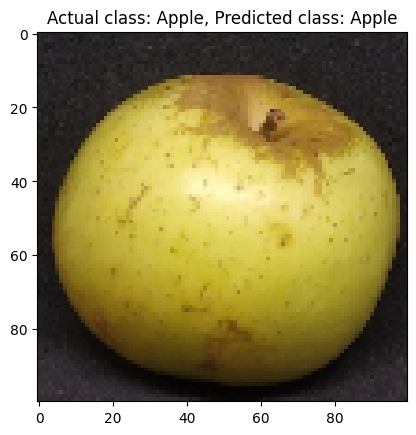

Sample 2: Actual class: Apple, Predicted class: Apple


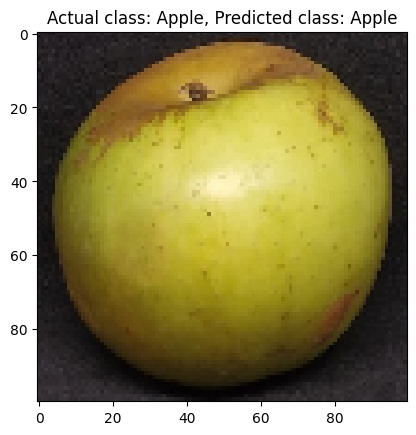

Sample 3: Actual class: Banana, Predicted class: Banana


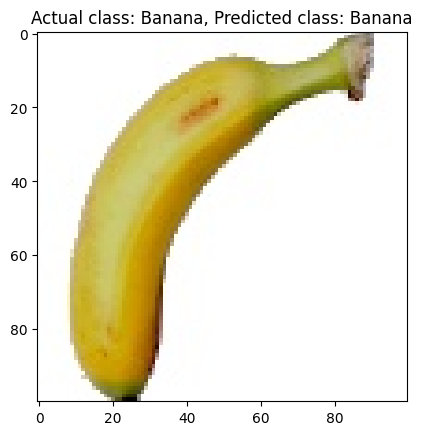

Sample 4: Actual class: Apple, Predicted class: Apple


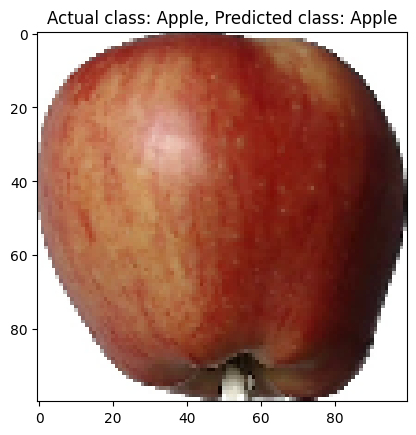

Sample 5: Actual class: Apple, Predicted class: Apple


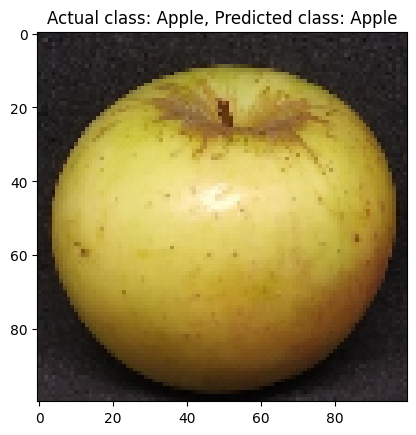

Sample 6: Actual class: Pear, Predicted class: Pear


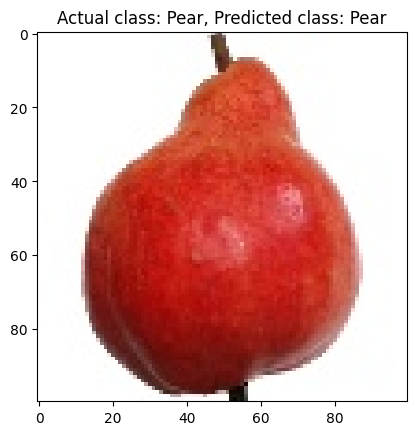

Sample 7: Actual class: Apple, Predicted class: Apple


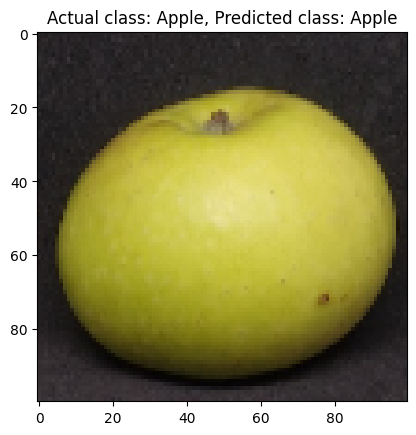

Sample 8: Actual class: Banana, Predicted class: Banana


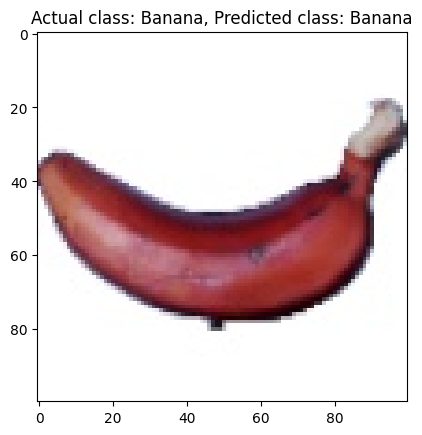

Sample 9: Actual class: Apple, Predicted class: Apple


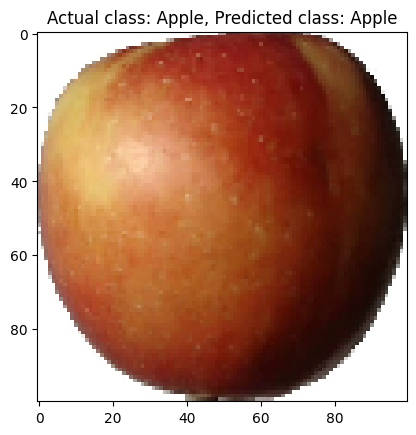

Sample 10: Actual class: Pear, Predicted class: Pear


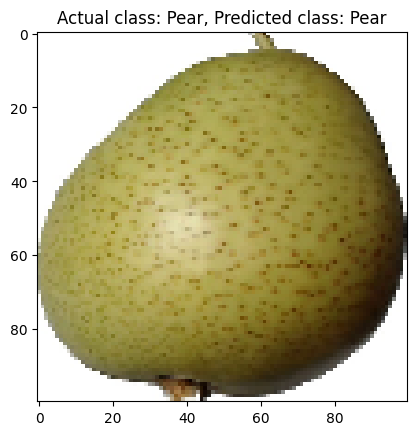

Sample 11: Actual class: Banana, Predicted class: Banana


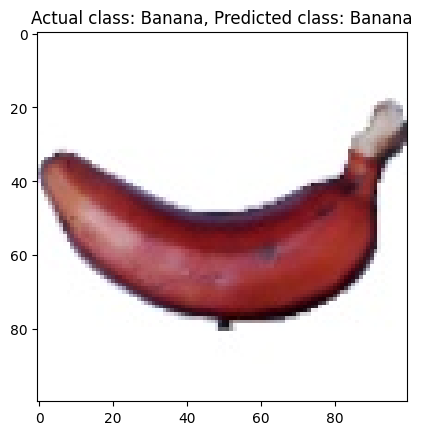

Sample 12: Actual class: Apple, Predicted class: Apple


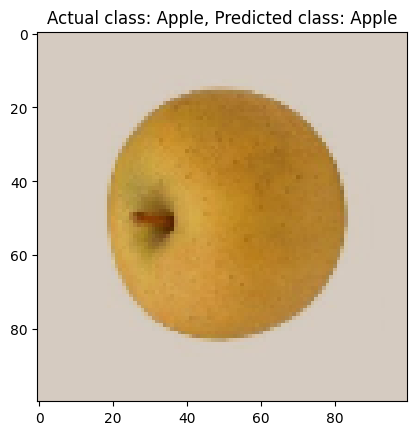

Sample 13: Actual class: Pear, Predicted class: Pear


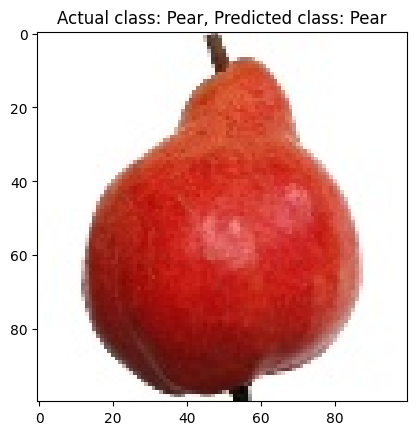

Sample 14: Actual class: Banana, Predicted class: Banana


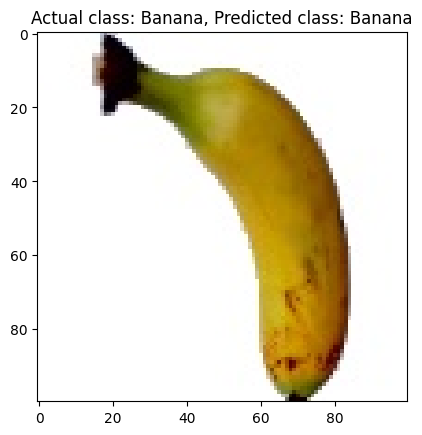

Sample 15: Actual class: Pear, Predicted class: Pear


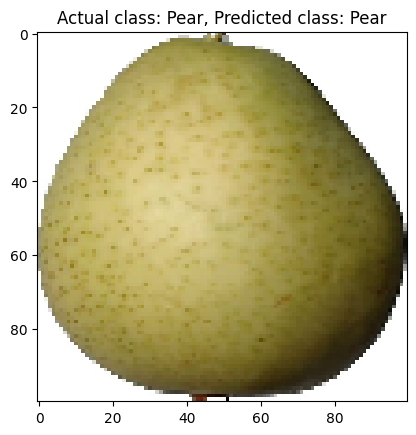

Sample 16: Actual class: Banana, Predicted class: Banana


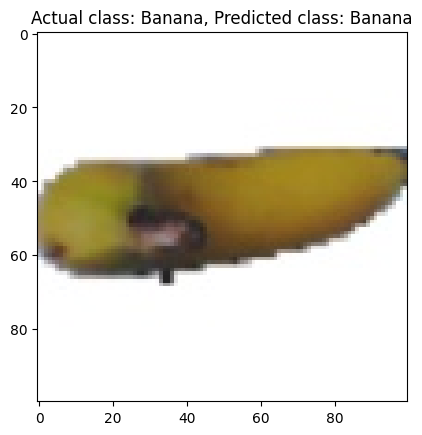

Sample 17: Actual class: Pear, Predicted class: Pear


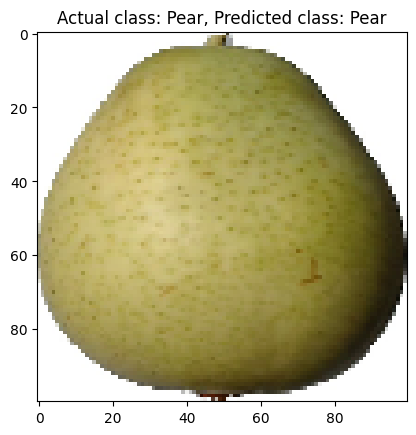

Sample 18: Actual class: Pear, Predicted class: Pear


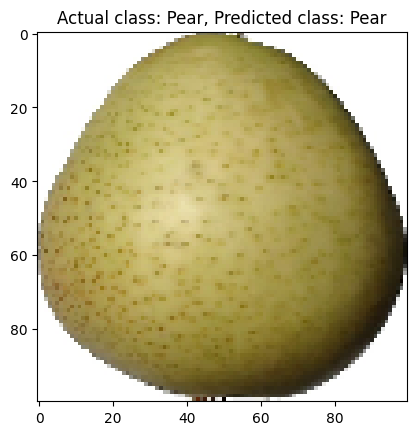

Sample 19: Actual class: Apple, Predicted class: Apple


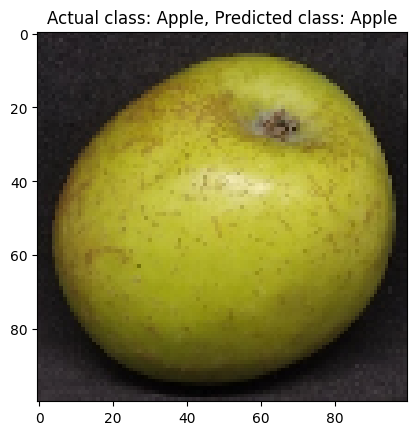

Sample 20: Actual class: Banana, Predicted class: Banana


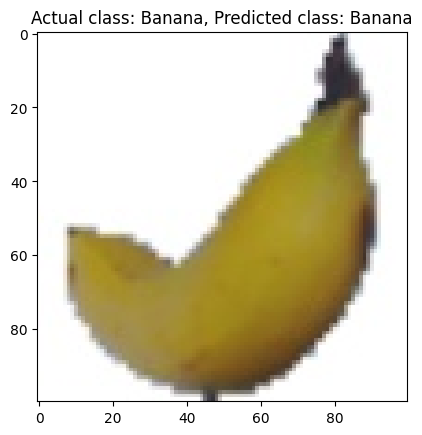

In [ ]:
# Predictions
predictions = model.predict(val_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images and predictions
for i in range(20):
    plt.imshow(val_images[i])

    # Map numeric label to actual class name
    actual_class_name = label_to_class[np.argmax(val_labels[i])]
    predicted_class_name = label_to_class[predicted_classes[i]]

    print(f"Sample {i+1}: Actual class: {actual_class_name}, Predicted class: {predicted_class_name}")

    plt.title(f"Actual class: {actual_class_name}, Predicted class: {predicted_class_name}")
    plt.show()

# Evaluation on seperate test set

1/1 [==============================] - 0s 19ms/step


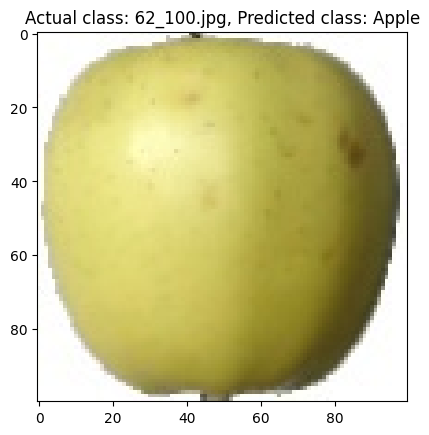

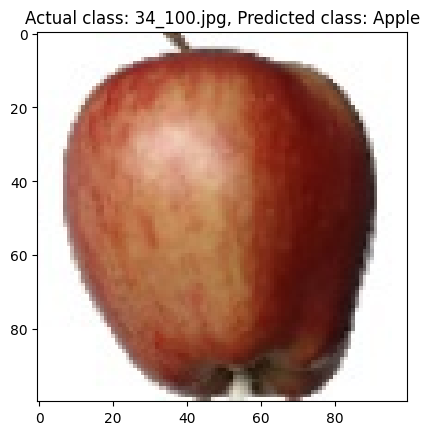

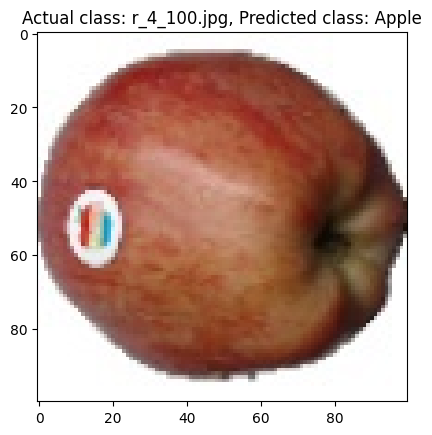

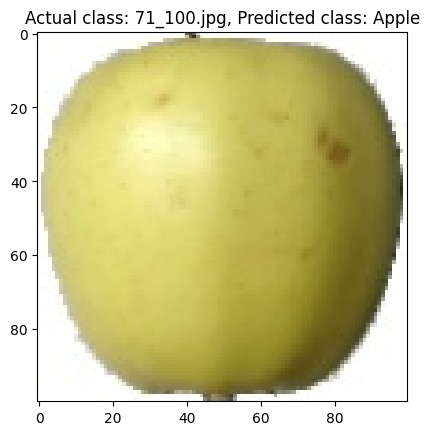

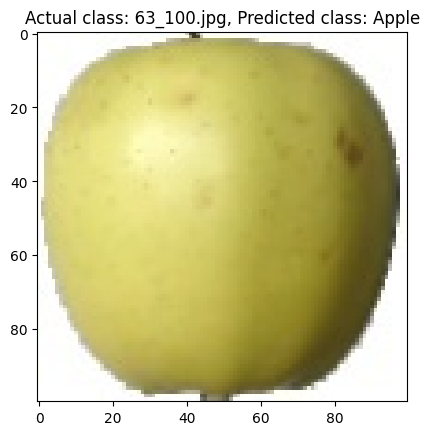

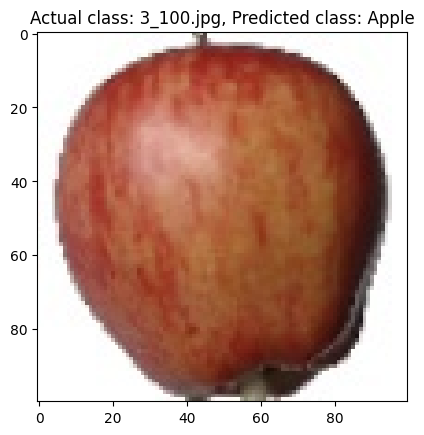

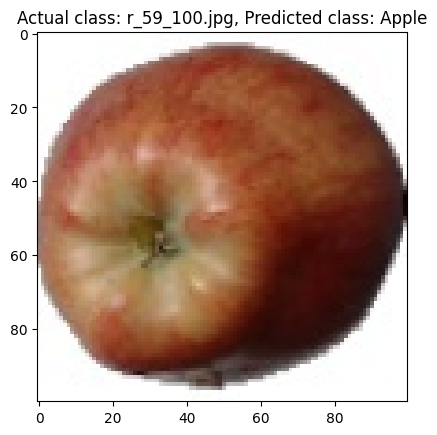

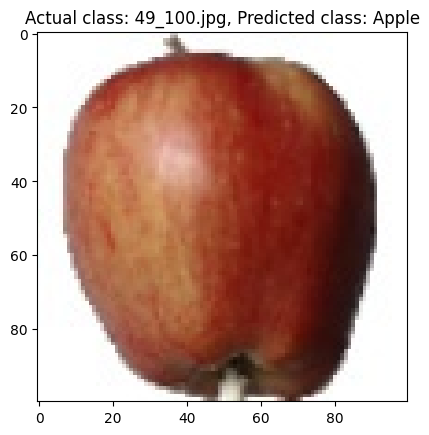

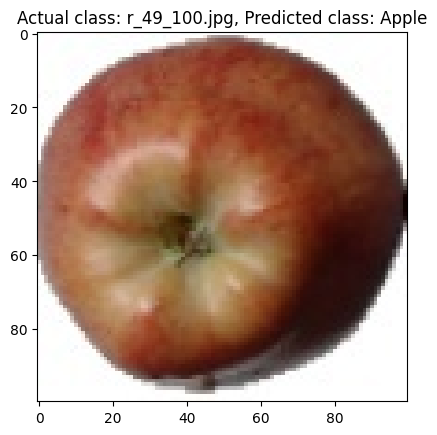

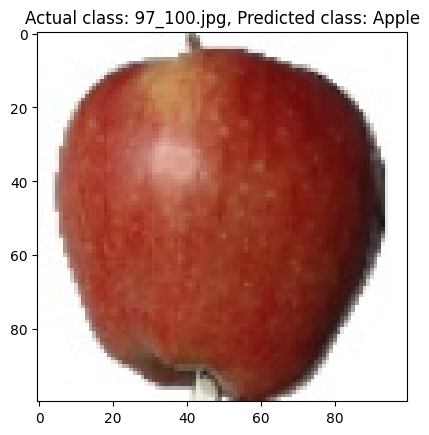

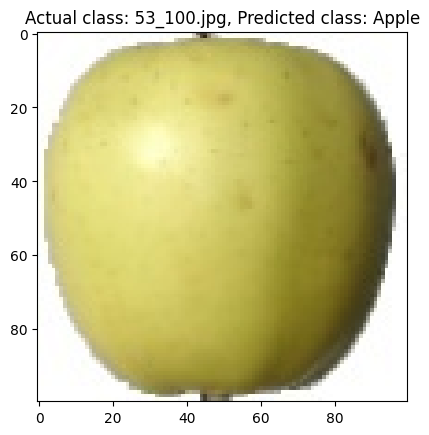

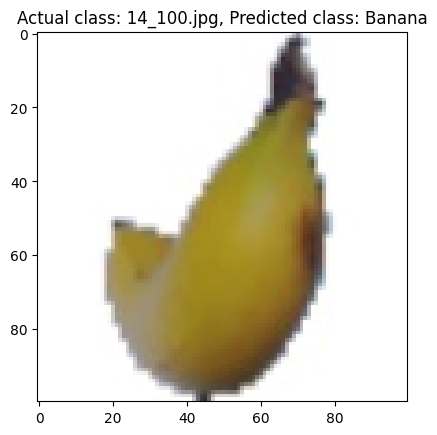

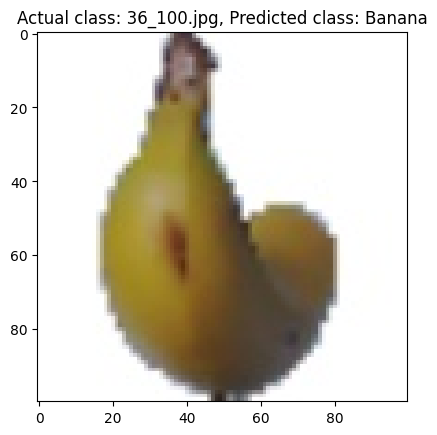

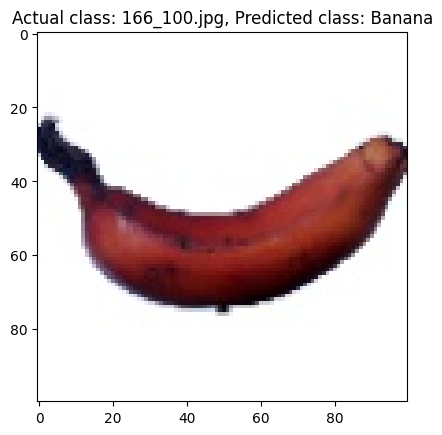

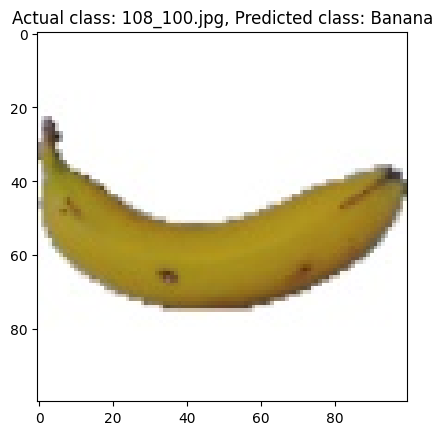

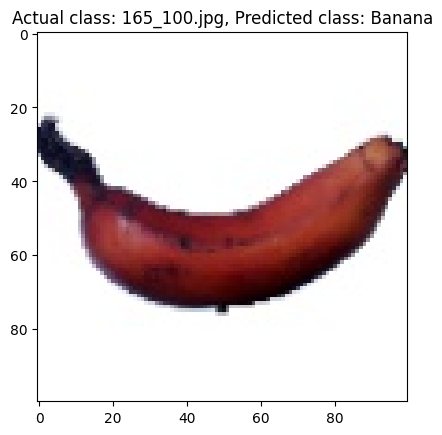

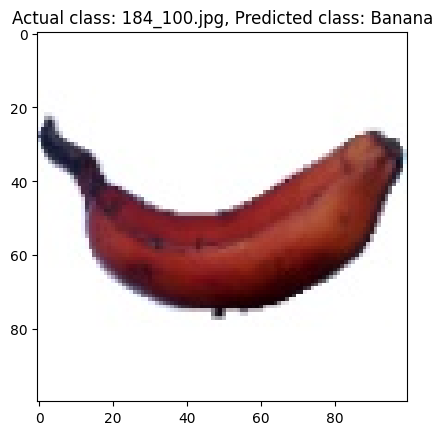

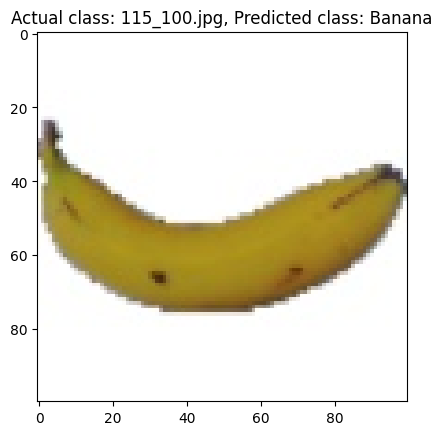

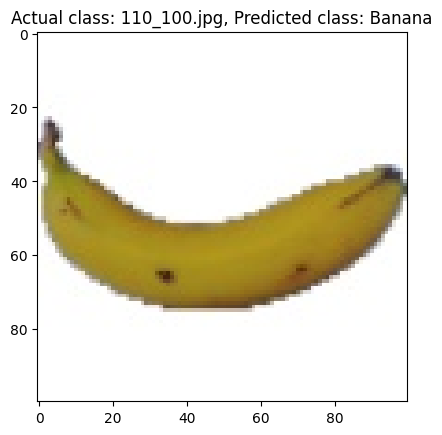

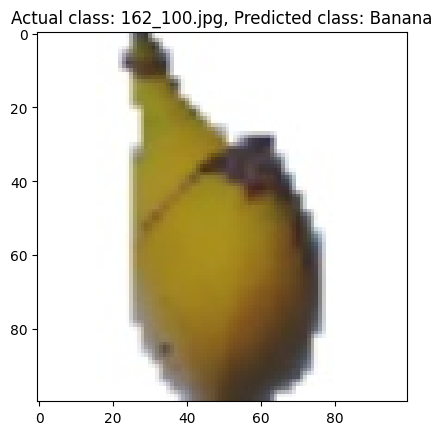

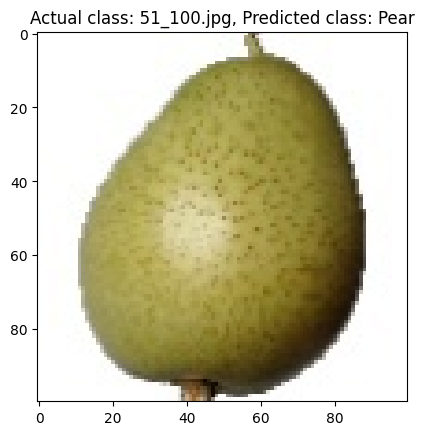

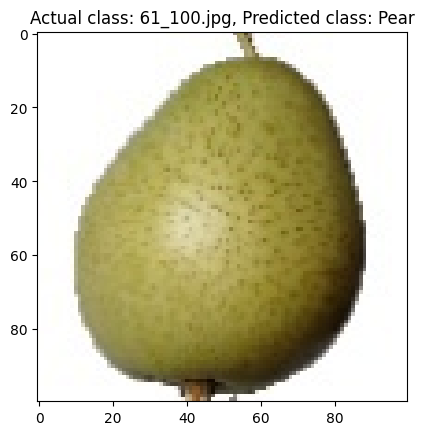

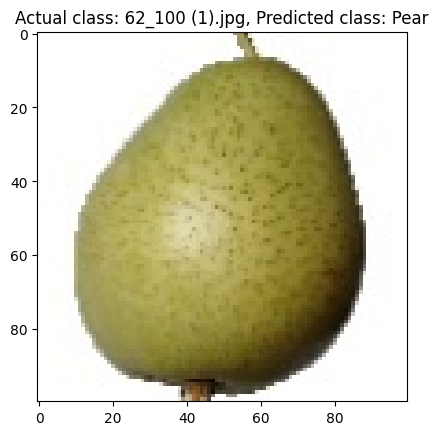

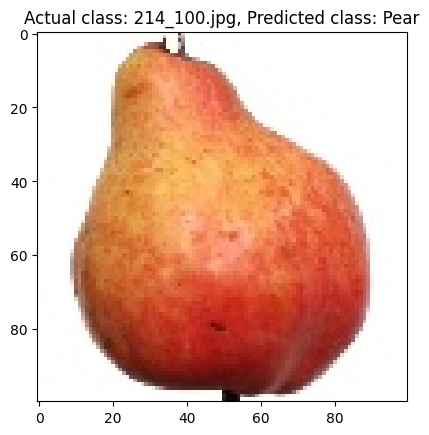

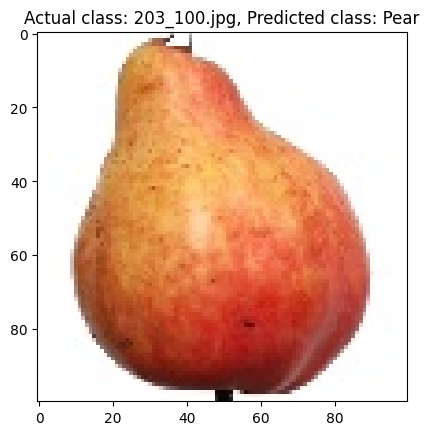

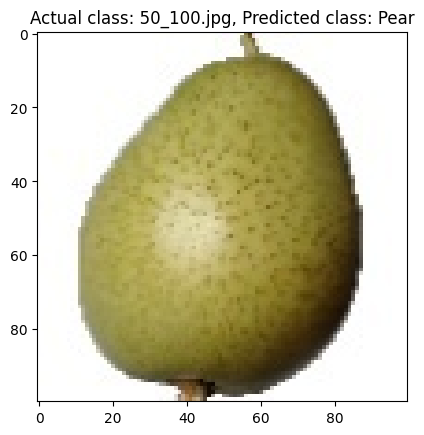

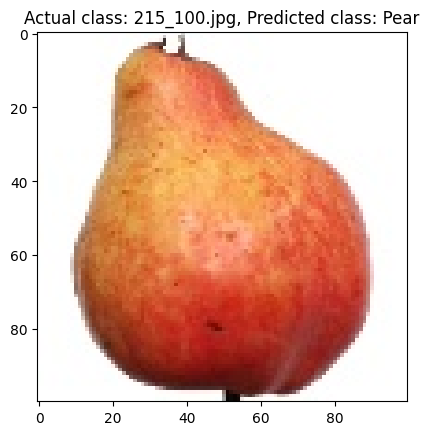

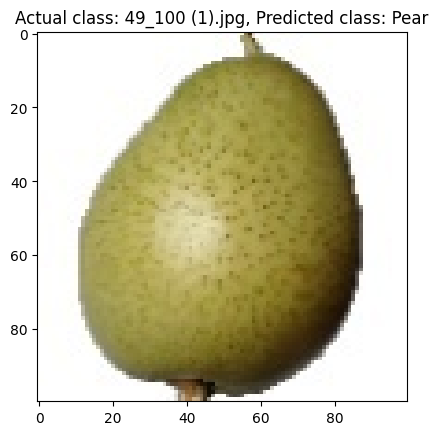

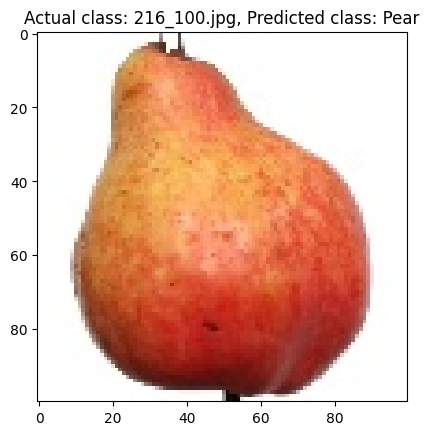

In [ ]:
import cv2
import numpy as np
import os

def load_and_preprocess_image(image_path, target_size=(100, 100)):
    """
    Load and preprocess a single image.

    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Desired size of the image.

    Returns:
        numpy.ndarray: Preprocessed image.
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at path: {image_path}")
        return None
    # Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Resize
    image = cv2.resize(image, target_size)
    # Normalize pixel values to [0, 1]
    image = image / 255.0
    # Expand dimensions to match model input shape (batch size = 1)
    image = np.expand_dims(image, axis=0)
    return image

# Directory containing test images
test_data_dir = '/content/drive/My Drive/Fruits Tests'

# Define mapping from class indices to class names
class_names = {0: 'Apple', 1: 'Banana', 2: 'Pear'}

# Make predictions for each test image
predictions = []
predicted_classes = []
actual_classes = []

# Load images from the test_data_dir folder
for filename in os.listdir(test_data_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Construct full path to the image
        image_path = os.path.join(test_data_dir, filename)
        # Load and preprocess the image
        preprocessed_image = load_and_preprocess_image(image_path)
        if preprocessed_image is not None:
            predictions.append(model.predict(preprocessed_image))
            actual_classes.append(filename)  # Assuming the file name represents the class
            # Predicted class will be determined after processing all images

# Display images and predictions
for i, actual_class_name in enumerate(actual_classes):
    image_path = os.path.join(test_data_dir, actual_class_name)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at path: {image_path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    actual_class = actual_class_name  # Assuming the file name represents the class
    predicted_class_index = np.argmax(predictions[i])  # Predicted class index
    predicted_class = class_names[predicted_class_index]  # Map predicted class index to class name
    plt.title(f"Actual class: {actual_class}, Predicted class: {predicted_class}")
    plt.show()